# **Setup**

In [13]:
import requests
import mediapipe as mp
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import json
import logging
import firebase_admin
import os

from firebase_admin import credentials, storage, firestore
from io import BytesIO
from PIL import Image

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# **Initialize Landmark**

c:\Users\Huawei\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_layer_12', 'input_layer_13']. Received: the structure of inputs=('*', '*')
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
Predicted class: A


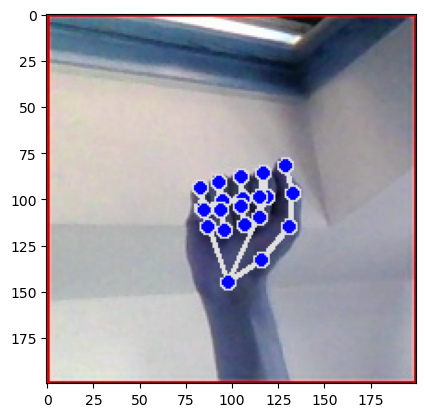

In [7]:
img_size = 32
max_hand_landmarks = 21 * 3 * 2

def pad_landmarks(landmarks, max_landmarks):
    if len(landmarks) < max_landmarks:
        return np.pad(landmarks, (0, max_landmarks - len(landmarks)), mode='constant')
    else:
        return landmarks[:max_landmarks]

def extract_hand_landmarks(image):
    hand_landmarks = []
    
    mp_hands = mp.solutions.hands
    with mp_hands.Hands(static_image_mode=True, max_num_hands=2) as hands:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        hand_results = hands.process(image_rgb)

        if hand_results.multi_hand_landmarks:
            for hand_landmark in hand_results.multi_hand_landmarks:
                for lm in hand_landmark.landmark:
                    hand_landmarks.extend([lm.x, lm.y, lm.z])

                mp.solutions.drawing_utils.draw_landmarks(image, hand_landmark, mp_hands.HAND_CONNECTIONS)

    padded_hand_landmarks = pad_landmarks(hand_landmarks, max_hand_landmarks)
    return np.array(padded_hand_landmarks)

def extract_and_process_hand_landmarks(image):
    hand_landmarks = extract_hand_landmarks(image)
    image_resized = cv2.resize(image, (32, 32)) / 255.0
    combined_input = np.concatenate([image_resized.flatten(), hand_landmarks])

    return combined_input

img_path = "A (1702).jpg"
image = cv2.imread(img_path)

if image is not None:
    hand_landmarks = extract_hand_landmarks(image)
    image_resized = cv2.resize(image, (img_size, img_size)) / 255.0
    
    image_input = image_resized.reshape(1, img_size, img_size, 3)
    landmark_input = hand_landmarks.reshape(1, max_hand_landmarks)
    
    model = tf.keras.models.load_model("gfgModelLM.h5")
    
    predicted_class_probabilities = model.predict([landmark_input, image_input])
    predicted_class = np.argmax(predicted_class_probabilities, axis=1)

    with open("encode.json", "r") as f:
        class_names = json.load(f)

    predicted_label = class_names[str(predicted_class[0])]
    
    print(f"Predicted class: {predicted_label}")
else:
    print("Error: Unable to load the image")

extract_and_process_hand_landmarks(image)
plt.imshow(image)

# **Production Gesture**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


'A'

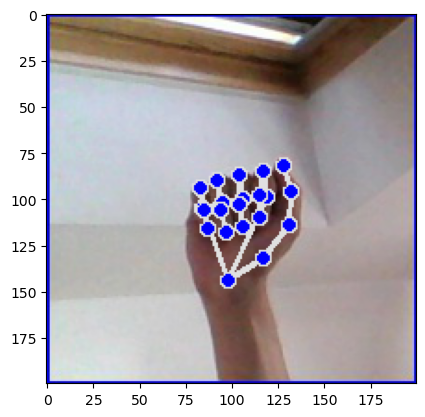

In [8]:
img_size = 32
max_hand_landmarks = 21 * 3 * 2

def pad_landmarks(landmarks, max_landmarks):
    if len(landmarks) < max_landmarks:
        return np.pad(landmarks, (0, max_landmarks - len(landmarks)), mode='constant')
    else:
        return landmarks[:max_landmarks]

def extract_hand_landmarks(image):
    hand_landmarks = []
    mp_hands = mp.solutions.hands
    
    image_np = np.array(image)
    
    with mp_hands.Hands(static_image_mode=True, max_num_hands=2) as hands:
        image_rgb = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)
        hand_results = hands.process(image_rgb)

        if hand_results.multi_hand_landmarks:
            for hand_landmark in hand_results.multi_hand_landmarks:
                for lm in hand_landmark.landmark:
                    hand_landmarks.extend([lm.x, lm.y, lm.z])

                mp.solutions.drawing_utils.draw_landmarks(image_np, hand_landmark, mp_hands.HAND_CONNECTIONS)

    padded_hand_landmarks = pad_landmarks(hand_landmarks, max_hand_landmarks)
    return image_np, np.array(padded_hand_landmarks)

def process_image_and_landmarks(image):
    image_with_landmarks, hand_landmarks = extract_hand_landmarks(image)
    
    image_resized = cv2.resize(image_with_landmarks, (img_size, img_size)) / 255.0

    image_input = image_resized.reshape(1, img_size, img_size, 3)
    landmark_input = hand_landmarks.reshape(1, max_hand_landmarks)
    
    return image_input, landmark_input, image_with_landmarks

def load_model(model_url, model_name):
    try:
        model_path = tf.keras.utils.get_file(model_name, origin=model_url)
        model = tf.keras.models.load_model(model_path)
        return model
    except Exception as e:
        raise Exception(f"Error loading the model: {str(e)}")

def predict_class(image_input, landmark_input):
    model = load_model('https://storage.googleapis.com/another-file-deployment/model/gfgModelLM.h5', 'gfgModelLM.h5')
    
    predicted_class_probabilities = model.predict([landmark_input, image_input])
    predicted_class = np.argmax(predicted_class_probabilities, axis=1)

    with open("encode.json", "r") as f:
        class_names = json.load(f)
    
    predicted_label = class_names[str(predicted_class[0])]
    return predicted_label

def display_image(image):
    plt.imshow(image)
    plt.savefig("image_with_landmarks.jpg")

def read_image(file: bytes) -> Image.Image:
    try:
        pil_image = Image.open(BytesIO(file))
        return pil_image
    except Exception as e:
        logger.error(f"Error reading image: {e}")
        raise e

def predict_gesture(image: bytes):
    try:
        image_input, landmark_input, image_with_landmarks = process_image_and_landmarks(image)
        predicted_label = predict_class(image_input, landmark_input)
        
        return {
            "prediction": predicted_label, 
            "image": image_with_landmarks
        }
    except Exception as e:
        logger.error(f"Error predicting gesture: {e}")
        raise e

def predict_image(image: bytes):
    try:
        pil_image = read_image(image)
        result = predict_gesture(pil_image)
        display_image(result["image"])
        
        return result["prediction"]
    except Exception as e:
        logger.error(f"Error predicting image: {e}")
        raise e

image = "A (1702).jpg"
with open(image, "rb") as f:
    img_bytes = f.read()
    
predict_image(img_bytes)

# **API Testing and Preprocess**

In [15]:
cred = credentials.Certificate("credentials.json")
firebase_admin.initialize_app(cred) if not firebase_admin._apps else firebase_admin.get_app()

db = firestore.client()
bucket = storage.bucket(
    name='signify-443314.appspot.com'
)

def upload_image_to_firebase(image_path):
    blob = bucket.blob('images/' + os.path.basename(image_path))
    blob.upload_from_filename(image_path)
    blob.make_public()
    return blob.public_url

def save_image_url_to_firestore(image_url):
    doc_ref = db.collection('images').add({
        'url': image_url,
        'timestamp': firestore.SERVER_TIMESTAMP
    })
    print(f"Document added with ID: {doc_ref}")

def main(image_path):
    image_url = upload_image_to_firebase(image_path)
    print(f"Image uploaded to: {image_url}")
    save_image_url_to_firestore(image_url)

image_path = 'image_with_landmarks.jpg'
main(image_path)

Image uploaded to: https://storage.googleapis.com/signify-443314.appspot.com/images/image_with_landmarks.jpg
Document added with ID: (DatetimeWithNanoseconds(2024, 12, 9, 17, 46, 1, 517818, tzinfo=datetime.timezone.utc), <google.cloud.firestore_v1.document.DocumentReference object at 0x0000010B553A43E0>)


In [16]:
def delete_collection(coll_ref, batch_size):
    docs = coll_ref.limit(batch_size).stream()
    deleted = 0

    for doc in docs:
        print(f'Deleting doc {doc.id} => {doc.to_dict()}')
        doc.reference.delete()
        deleted = deleted + 1

    if deleted >= batch_size:
        return delete_collection(coll_ref, batch_size)
    
def delete_images():
    coll_ref = db.collection('images')
    delete_collection(coll_ref, 10)

delete_images()

Deleting doc Qrw6GGUh6KxcbvCmlqPV => {'timestamp': DatetimeWithNanoseconds(2024, 12, 9, 17, 46, 1, 501000, tzinfo=datetime.timezone.utc), 'url': 'https://storage.googleapis.com/signify-443314.appspot.com/images/image_with_landmarks.jpg'}


In [17]:
cred = credentials.Certificate("credentials.json")
firebase_admin.initialize_app(cred) if not firebase_admin._apps else firebase_admin.get_app()

db = firestore.client()

docs = db.collection(u'predictions').stream()
for doc in docs:
    print(f'{doc.id} => {doc.to_dict()}')

docs = db.collection(u'predictions').stream()
for doc in docs:
    doc.reference.delete()

In [18]:
# url = "http://127.0.0.1:8000/predict"
url = "https://hand-gesture-signify-930248014296.asia-southeast2.run.app/predict"
file_path = "A (1702).jpg"

with open(file_path, "rb") as f:
    files = {"file": f}
    response = requests.post(url, files=files)

response.json()

{'message': 'Prediction successful.',
 'detection': 'A',
 'timestamp': '2024-12-09 17:46:56',
 'image': 'https://storage.googleapis.com/signify-443314.appspot.com/images/tmp3mkzufht.jpg'}